## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [15]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [16]:
train, test = keras.datasets.cifar10.load_data()

In [17]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [18]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [19]:
x_train = x_train[:5000]
x_test = x_test[:5000]
y_train = y_train[:5000]
y_test = y_test[:5000]

In [25]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = 0.25
L2_RATIO = 0.01

In [21]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [22]:
# from tensorflow.keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp_dropout(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.Dropout(drp_ratio)(x) ## dropout function has bug: https://github.com/tensorflow/tensorflow/issues/23410
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [23]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp_regulizer(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [35]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp_batchnorm(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [28]:
def choose_model(model_type, input_shape):
    if model_type == 'dropout':
        return build_mlp_dropout(x_train.shape[1:])
    elif model_type == 'regulizer':
        return build_mlp_regulizer(x_train.shape[1:])
    elif model_type == 'batch_normalizer':
        return build_mlp_batchnorm(x_train.shape[1:])

In [36]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for model_type in ['dropout', 'regulizer', 'batch_normalizer']:
    try:
        keras.backend.clear_session() # 把舊的 Graph 清掉
    except:
        pass

    model = choose_model(model_type, input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
        
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-{model_type}".format(model_type=model_type)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0   

Epoch 47/50
5000/5000 [==============================] - 1s 155us/step - loss: 1.4269 - accuracy: 0.4780 - val_loss: 1.6863 - val_accuracy: 0.4152
Epoch 48/50
5000/5000 [==============================] - 1s 156us/step - loss: 1.4263 - accuracy: 0.4884 - val_loss: 1.6776 - val_accuracy: 0.4134
Epoch 49/50
5000/5000 [==============================] - 1s 157us/step - loss: 1.3975 - accuracy: 0.4876 - val_loss: 1.6475 - val_accuracy: 0.4170
Epoch 50/50
5000/5000 [==============================] - 1s 160us/step - loss: 1.3868 - accuracy: 0.4972 - val_loss: 1.6863 - val_accuracy: 0.4128
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________

5000/5000 [==============================] - 2s 317us/step - loss: 0.8577 - accuracy: 0.7292 - val_loss: 1.9391 - val_accuracy: 0.4384
Epoch 46/50
5000/5000 [==============================] - 1s 267us/step - loss: 0.8349 - accuracy: 0.7348 - val_loss: 1.9665 - val_accuracy: 0.4268
Epoch 47/50
5000/5000 [==============================] - 2s 304us/step - loss: 0.7866 - accuracy: 0.7564 - val_loss: 2.0695 - val_accuracy: 0.4174
Epoch 48/50
5000/5000 [==============================] - 2s 372us/step - loss: 0.8473 - accuracy: 0.7236 - val_loss: 1.9961 - val_accuracy: 0.4210
Epoch 49/50
5000/5000 [==============================] - 2s 339us/step - loss: 0.8252 - accuracy: 0.7400 - val_loss: 2.0632 - val_accuracy: 0.4166
Epoch 50/50
5000/5000 [==============================] - 2s 410us/step - loss: 0.8098 - accuracy: 0.7468 - val_loss: 2.1191 - val_accuracy: 0.4302
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape      

Epoch 41/50
5000/5000 [==============================] - 1s 195us/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 2.8347 - val_accuracy: 0.4132
Epoch 42/50
5000/5000 [==============================] - 1s 209us/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.8734 - val_accuracy: 0.4136
Epoch 43/50
5000/5000 [==============================] - 1s 189us/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 2.8859 - val_accuracy: 0.4122
Epoch 44/50
5000/5000 [==============================] - 1s 197us/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 2.8638 - val_accuracy: 0.4144
Epoch 45/50
5000/5000 [==============================] - 1s 183us/step - loss: 0.0043 - accuracy: 0.9996 - val_loss: 2.8780 - val_accuracy: 0.4114
Epoch 46/50
5000/5000 [==============================] - 1s 239us/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.9450 - val_accuracy: 0.4076
Epoch 47/50
5000/5000 [==============================] - 1s 185us/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 2

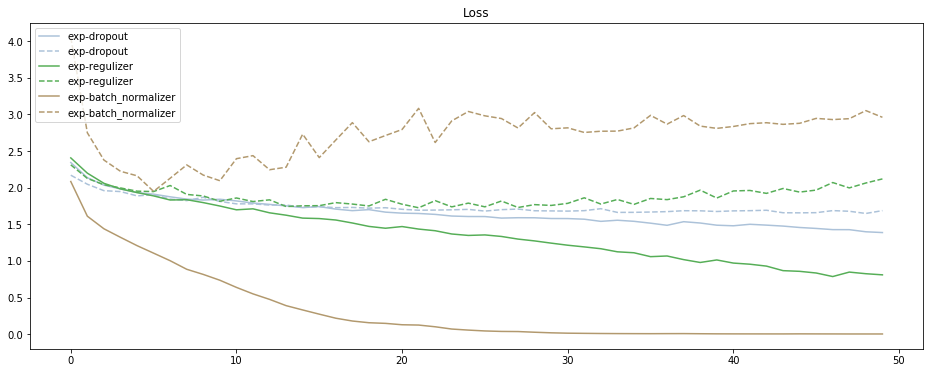

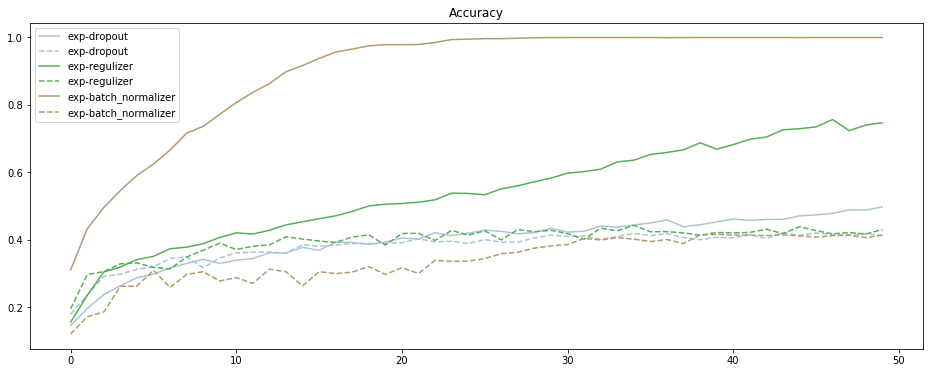

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
color_bar = list(colors._colors_full_map.values())

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()